# Exploring differences in word frequencies used between corpuses

## Graphs and visuals

Lets generate some visualizations showing which words are more likely to show up in each corpus, as well as find ones that tend to be more prominent in only one

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.feature_extraction import text
import sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from path import DATA_PROCESSED_DOCUMENTS_DIR, DATA_EXTERNAL_DIR

In [2]:
fn_df = pd.read_csv(DATA_EXTERNAL_DIR / "firstnames.csv")
ln_df = pd.read_csv(DATA_EXTERNAL_DIR / "censusSurnames.csv")

In [3]:
# Add names to stop words
name_list = fn_df["firstname"].tolist() + ln_df["surname"].tolist()
test = CountVectorizer(stop_words="english")
test1 = test.fit_transform(name_list)
word_list = test.get_feature_names_out()
name_stop_words = word_list.tolist()
STOP_WORDS = list(text.ENGLISH_STOP_WORDS.union(name_stop_words))

In [4]:
# Build a dictionary of all the words in the documents used in the "Black-or-African-American" folder
# mapping each word to the number of times it was seen.
# ex.
# print(b_word_freq) # prints a dict showing that the word abdominal appeared 410 times
# { ..., 'abdominal': 410, ...}
folder_location = DATA_PROCESSED_DOCUMENTS_DIR / "black-or-african-american"
docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        docs.append(open(f))
cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
cv_fit = cv.fit_transform(docs)
word_list = cv.get_feature_names_out()
count_list = cv_fit.toarray().sum(axis=0)

for fh in docs:
    fh.close()

b_word_freq = dict(zip(word_list, count_list))

In [5]:
# Build a dictionary of all the words in the documents used in the "White-or-Caucasian" folder
folder_location = DATA_PROCESSED_DOCUMENTS_DIR / "white-or-caucasian"
docs = []
for filename in os.listdir(folder_location):
    f = os.path.join(folder_location, filename)
    # checking if it is a file
    if os.path.isfile(f):
        docs.append(open(f))
cv = CountVectorizer(input="file", stop_words=STOP_WORDS)
cv_fit = cv.fit_transform(docs)
word_list = cv.get_feature_names_out()
count_list = cv_fit.toarray().sum(axis=0)

for fh in docs:
    fh.close()

w_word_freq = dict(zip(word_list, count_list))

[Text(0.5, 1.0, 'w word freq')]

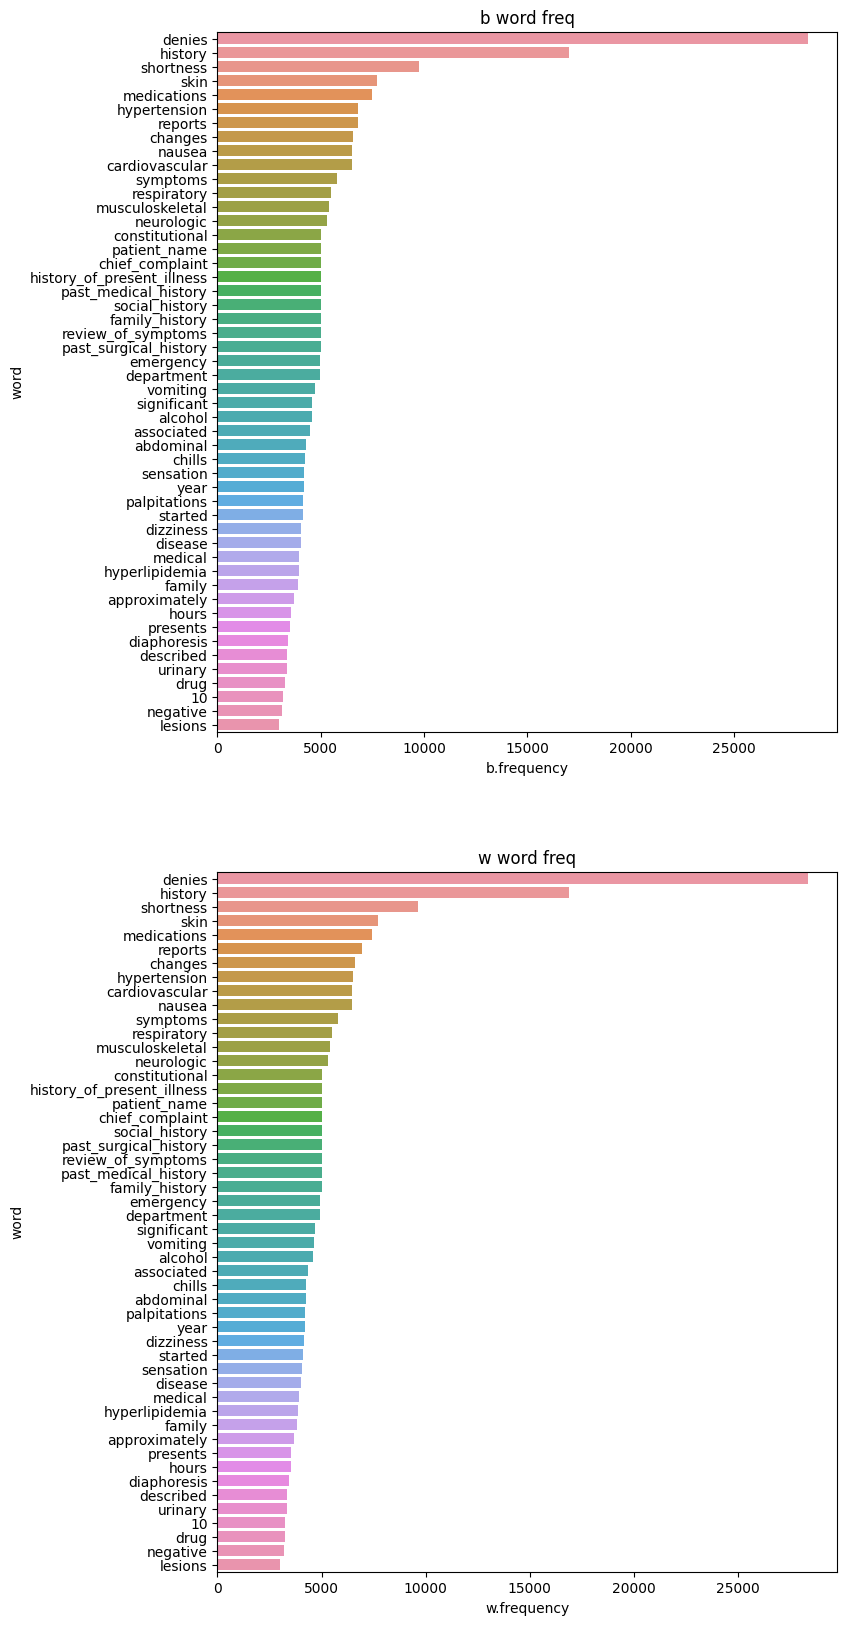

In [6]:
# Quick plot to see which words are used most in each data set
b_word_freq_df = pd.DataFrame(
    b_word_freq.items(), columns=["word", "b.frequency"]
).sort_values(by="b.frequency", ascending=False)
w_word_freq_df = pd.DataFrame(
    w_word_freq.items(), columns=["word", "w.frequency"]
).sort_values(by="w.frequency", ascending=False)
fig, axes = plt.subplots(2, 1, figsize=(8, 20))
sns.barplot(ax=axes[0], x="b.frequency", y="word", data=b_word_freq_df.head(50)).set(
    title="b word freq"
)
sns.barplot(ax=axes[1], x="w.frequency", y="word", data=w_word_freq_df.head(50)).set(
    title="w word freq"
)

In [7]:
# Inner join the b and w tables on words to combine freq between both tables
wf_df = w_word_freq_df.merge(b_word_freq_df, how="inner", on="word")

In [8]:
# We don't want to sort on the most common freq for w vs b especially if the frequencies are similar, instead we care about where these frequencies differ
# Create a new column that calculates the difference in freq of words between datasets and sort by the diff
wf_df["w.frequency_pct"] = wf_df["w.frequency"] / wf_df["w.frequency"].sum()
wf_df["b.frequency_pct"] = wf_df["b.frequency"] / wf_df["b.frequency"].sum()
wf_df["frequency_pct_diff"] = wf_df["b.frequency_pct"] - wf_df["w.frequency_pct"]
wf_df["frequency_pct_diff_abs"] = wf_df["frequency_pct_diff"].abs()
# Sort by largest values in absolue difference
wf_df.sort_values(by="frequency_pct_diff", ascending=False).head(10)

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
7,hypertension,6498,6812,0.014283,0.014956,0.000673,0.000673
0,denies,28358,28566,0.062335,0.062718,0.000383,0.000383
76,reported,1557,1694,0.003422,0.003719,0.000297,0.000297
1,history,16879,17014,0.037102,0.037355,0.000253,0.000253
63,previous,2156,2267,0.004739,0.004977,0.000238,0.000238
119,lightheadedness,734,841,0.001613,0.001846,0.000233,0.000233
35,sensation,4064,4171,0.008933,0.009158,0.000224,0.000224
28,associated,4368,4475,0.009601,0.009825,0.000224,0.000224
55,complaints,2489,2590,0.005471,0.005686,0.000215,0.000215
106,numbness,876,966,0.001926,0.002121,0.000195,0.000195


In [9]:
# There are a lot of numbers in the notes. lets look at the spread between corpuses
mask = wf_df["word"].str.isnumeric()
nums_df = (
    wf_df[mask]
    .sort_values(by="frequency_pct_diff_abs", ascending=False)
    .sort_values(by="frequency_pct_diff", ascending=False)
)
aa_chart_data = []
ca_chart_data = []
for row in nums_df.iterrows():
    if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
        # orange bars
        aa_chart_data.append(row[1]["word"])
    else:
        # blue bars
        ca_chart_data.append(row[1]["word"])

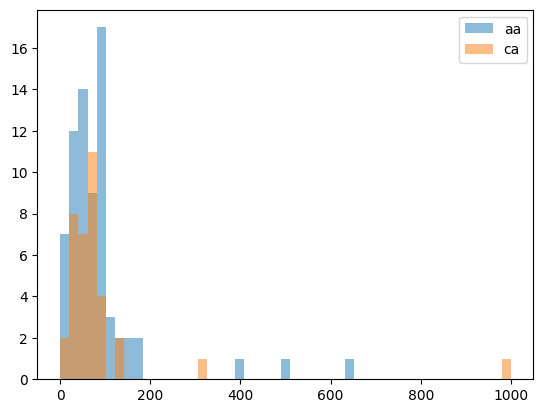

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy
from matplotlib import pyplot

x = [int(x) for x in aa_chart_data]
y = [int(x) for x in ca_chart_data]

bins = numpy.linspace(0, 1000)

pyplot.hist(x, bins, alpha=0.5, label="aa")
pyplot.hist(y, bins, alpha=0.5, label="ca")
pyplot.legend(loc="upper right")
pyplot.show()

In [11]:
len(docs)

5000

# chi-square, categorical

In [12]:
# First order frequencies by magnature of difference (absolute value), take the top 200 words with the greatest difference,
# then re-sort by actual difference so when we plot the values will be sequential from smallest to largest bars
most = (
    wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
    .head(200)
    .sort_values(by="frequency_pct_diff", ascending=False)
)

aa = most["b.frequency"].tolist()
ca = most["w.frequency"].tolist()
words = most["word"].tolist()
c_table = most.T
c_table.columns = c_table.iloc[0]
c_table = c_table.drop(
    labels=[
        "word",
        "w.frequency_pct",
        "b.frequency_pct",
        "frequency_pct_diff",
        "frequency_pct_diff_abs",
    ]
)
c_table

word,hypertension,denies,reported,history,previous,lightheadedness,sensation,associated,complaints,numbness,...,infarction,dizziness,myocardial,negative,syncope,located,mg,significant,complaint,reports
w.frequency,6498,28358,1557,16879,2156,734,4064,4368,2489,876,...,1221,4146,1232,3188,779,1598,1552,4689,2947,6955
b.frequency,6812,28566,1694,17014,2267,841,4171,4475,2590,966,...,1138,4066,1143,3101,683,1500,1449,4584,2819,6785


In [13]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [14]:
sig_results = []
# Chi square independence test
# https://www.dir.uniupo.it/pluginfile.php/138296/mod_resource/content/0/22-colloc-bw.pdf
for k in list(set(words)):
    # For AA [Number of instances of current word, Number of instances of all other words]
    x1 = [c_table[k].iloc[0], c_table.iloc[0].sum() - c_table[k].iloc[0]]
    # For CA [Number of instances of current word, Number of instances of all other words]
    y1 = [c_table[k].iloc[1], c_table.iloc[1].sum() - c_table[k].iloc[1]]
    test = scipy.stats.chi2_contingency([x1, y1])
    word = c_table[k].name
    if test.pvalue < 0.01:
        print(f"Word: {k}")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There is a significant difference in the frequency of the word {word} with a p-value of {bcolors.OKGREEN + "{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
            + bcolors.ENDC
        )
        print(f"")
        sig_results.append(word)
    elif test.pvalue < 0.05:
        print(f"Word: {k}")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There is a significant difference in the frequency of the word {word} with a p-value of {bcolors.OKGREEN +"{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
        )
        print(f"")
        sig_results.append(word)

    # else:
    #     print(
    #         f'There was no significant difference in the frequency of the word {word} with a p-value of {"{:0.3f}".format(test.pvalue)}'
    #     )

Word: wife
AA: [48, 287166]
CA: [80, 287922]
There is a significant difference in the frequency of the word wife with a p-value of 0.006

Word: undergone
AA: [82, 287132]
CA: [58, 287944]
There is a significant difference in the frequency of the word undergone with a p-value of 0.050

Word: denied
AA: [78, 287136]
CA: [113, 287889]
There is a significant difference in the frequency of the word denied with a p-value of 0.015

Word: lightheadedness
AA: [734, 286480]
CA: [841, 287161]
There is a significant difference in the frequency of the word lightheadedness with a p-value of 0.009

Word: treatment
AA: [8, 287206]
CA: [32, 287970]
There is a significant difference in the frequency of the word treatment with a p-value of 0.000

Word: occurred
AA: [42, 287172]
CA: [23, 287979]
There is a significant difference in the frequency of the word occurred with a p-value of 0.025

Word: diabetes
AA: [449, 286765]
CA: [515, 287487]
There is a significant difference in the frequency of the word di

In [15]:
# Positive Negative Bar Chart to better visualize where word frequencies diverge between data sets
# Based on https://stackoverflow.com/a/69976552/11407943
import numpy as np
import matplotlib.pyplot as plt


category_names = ["white-or-caucasian", "black-or-african-american"]

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = 0  # data[:, range(middle_index)].sum(axis=1) # + data[:, middle_index]/2

    # Color Mapping
    category_colors = plt.get_cmap("coolwarm_r")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    # Add Zero Reference Line
    ax.axvline(0, linestyle="--", color="black", alpha=0.25)

    # X Axis
    ax.set_xlim(-0.0008, 0.0008)
    # ax.set_xticks(np.arange(-0.0035, 0.0035, 0.003))
    ax.xaxis.set_major_formatter(lambda x, pos: str(x))

    # Y Axis
    ax.invert_yaxis()

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ledgend
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 0.99),
        loc="lower left",
        fontsize="small",
    )

    # Set Background Color
    fig.set_facecolor("#FFFFFF")

    return fig, ax

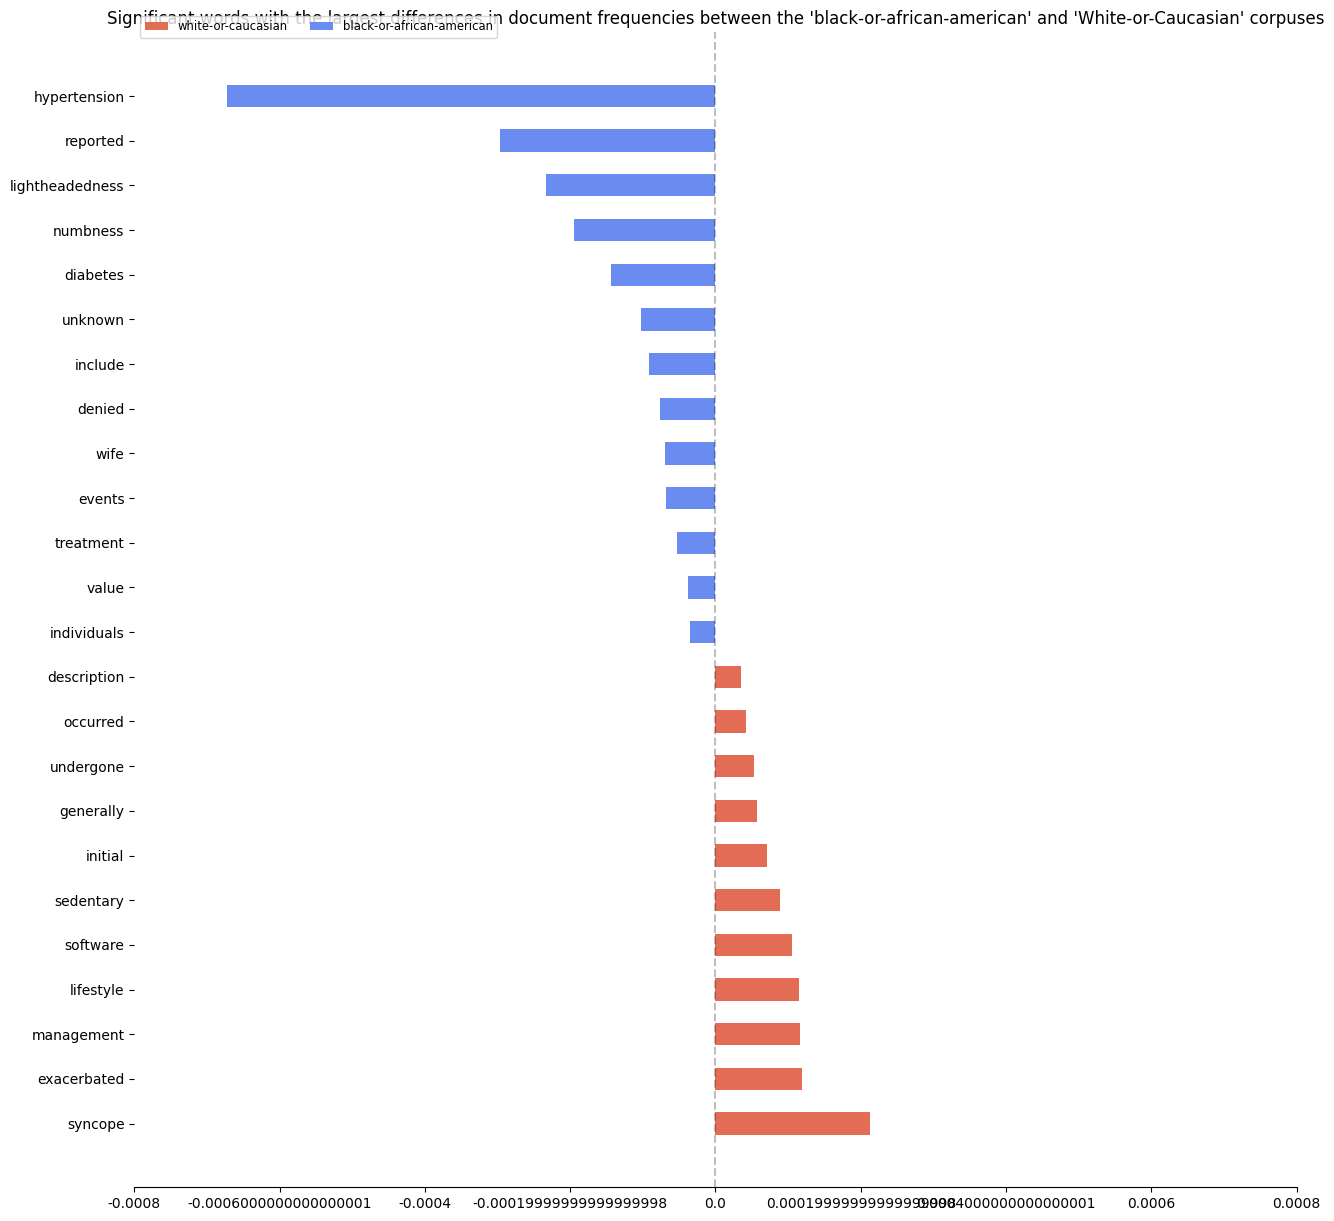

In [16]:
chart_data = {}

# Create a map with the word as the frequency, and the magnitude vector as the value\
# a vector of [0, n] will plot a blue bar
# a vector of [n, 0] will plot an orange bar
# a vector with a negative n [-n, 0] will plot a bar on the left
# a vector with a positive n [n, 0] will plot a bar on the right
# {"word": [-1, 0]} will plot an orange bar for "word" on the left of 0 with length 1
# {"word": [0, 0.5]} will plot a blue bar for "word" on the right of 0 with length 0.5
# in order to generate a good Positive Negative bar chart, we assign b freq to the left side (negative)
# and w freq to the right side (positive)
for row in most.iterrows():
    if row[1]["word"] in sig_results and not row[1]["word"].isnumeric():
        if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
            # orange bars
            chart_data[row[1]["word"]] = [
                row[1]["w.frequency_pct"] - row[1]["b.frequency_pct"],
                0,
            ]
        else:
            # blue bars
            chart_data[row[1]["word"]] = [
                0,
                -(row[1]["b.frequency_pct"] - row[1]["w.frequency_pct"]),
            ]

fig, ax = survey(chart_data, category_names)
plt.title(
    "Significant words with the largest differences in document frequencies between the 'black-or-african-american' and 'White-or-Caucasian' corpuses"
)
plt.show()

# These results are just for exploratory analysis

![significant](https://imgs.xkcd.com/comics/significant.png)